# Dermatorlogist AI

We will design an algorithm that can visually diagnose **melanoma**, the deadliest from of skin cancer.

The algorithm will distinguish this malignant skin tummor from two types of benign lesions (**Nevus**, **Seborrheic keratosis**)

![skin tumor](images/skin_disease_classes.png)

### Import Libraries

In [1]:
import torch 
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import os

from torchvision import datasets, transforms

In [2]:
# Data loaders for training, validation, and test sets
# Using meand and std dev from the ImageNet dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define Batch size
BATCH_SIZE = 20

# Composition of the transforms
data_transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

# Load images
train_set = datasets.ImageFolder(root='data/test', transform=data_transform)
train_loader = torch.utils.data.DataLoader(train_set, BATCH_SIZE, shuffle=True, num_workers=2)

In [3]:
# Loading classes
classes = train_set.classes
print('Classes: ', classes)
n_classes = len(train_set.classes)

Classes:  ['melanoma', 'nevus', 'seborrheic_keratosis']


### Visualize the data

In [4]:
data_iter = iter(train_loader)
images, classes_ = data_iter.next()

In [5]:
# Function to return an unnormalized image
def img_show(img, mean, std):
    img = img * std[:, None, None] + mean[:, None, None] # unnormalize
    np_img = img.numpy()
    return np.transpose(np_img, (1, 2, 0))

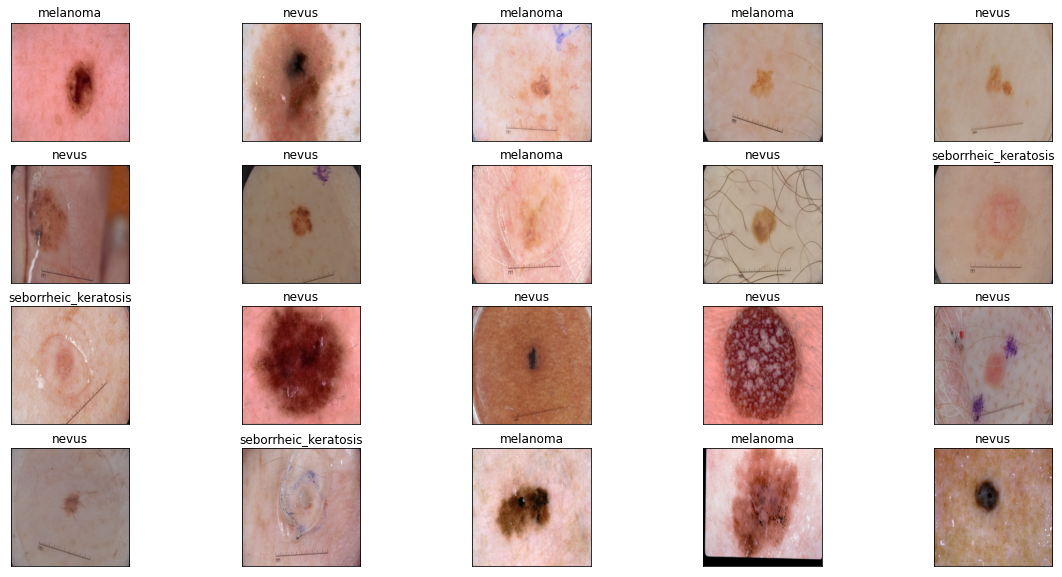

In [7]:
# Plot the images in the batch with their corresponding class names
fig = plt.figure(figsize=(20, 10))
for idx in np.arange(BATCH_SIZE):
    ax = fig.add_subplot(4, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(img_show(images[idx], torch.Tensor(mean), torch.Tensor(std)))
    ax.set_title(classes[classes_[idx]])
plt.show()

### Initialize CUDA variable

In [12]:
use_cuda = torch.cuda.is_available()
print('Use CUDA: ', use_cuda)

Use CUDA:  False
